# Plotting Hubble Residuals
 
Creates Hubble diagram and plots residuals

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
from astropy.cosmology import FlatLambdaCDM
from astropy import units as u
from scipy.stats import chisquare
from scipy.optimize import minimize


In [2]:
sdss_combined = pd.read_csv('../results/sdss_combined.csv')


## Finding a Best Fit Cosmology

In [3]:
Om0_assumed = 0.315
redshift = sdss_combined['zCMB']
dist_mod = sdss_combined['muSALT2zspec'].to_numpy()
dist_mod_err = sdss_combined['muerrSALT2zspec']


In [4]:
#@np.vectorize
#def dist_mod_chisq(H0):
    #cosmo = FlatLambdaCDM(H0=H0 * u.km / u.s / u.Mpc, Om0=Om0_assumed)
    #model_dist_mod = cosmo.distmod(redshift)
    #chisq, p = chisquare(dist_mod * u.mag, model_dist_mod)
    #return chisq / u.mag


In [22]:
@np.vectorize
def chisq(H0):
    data_err = sdss_combined['muerrSALT2zspec']
    cosmo = FlatLambdaCDM(H0=H0 * u.km / u.s / u.Mpc, Om0=Om0_assumed)
    model_dist_mod = cosmo.distmod(redshift)
    mu = np.mean(model_dist_mod)
    chisq_total = 0
    for x, xerr in zip(model_dist_mod, data_err * u.mag):
        chisq = ((x - mu)**2)/(xerr**2)
        chisq_total += chisq
    return(chisq_total)

In [35]:
fit_results = minimize(chisq, 70)
fit_results

      fun: 31686.214943498675
 hess_inv: array([[0.00627361]])
      jac: array([-0.00048828])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 19
      nit: 1
     njev: 6
   status: 2
  success: False
        x: array([69.99998775])

In [34]:
#fit_results = minimize(dist_mod_chisq, 70)
#fit_results


      fun: 0.716862944405646
 hess_inv: array([[24.57484395]])
      jac: array([8.12858343e-06])
  message: 'Optimization terminated successfully.'
     nfev: 18
      nit: 4
     njev: 6
   status: 0
  success: True
        x: array([68.32005572])

In [36]:
H0_fit = fit_results.x[0] * u.km / u.s / u.Mpc
our_cosmo = FlatLambdaCDM(H0=H0_fit, Om0=Om0_assumed)
our_cosmo


FlatLambdaCDM(H0=70 km / (Mpc s), Om0=0.315, Tcmb0=0 K, Neff=3.04, m_nu=None, Ob0=None)

## Plot Fit Results

In [37]:
def plot_hubble_diagram(z, mu, mu_err, fitted_cosmo, figsize=(4, 6)):

    xlim = np.min(z), np.max(z)
    z_plot = np.linspace(*xlim)
    fitted_dist_mod = our_cosmo.distmod(z_plot)
    
    fig, (top_ax, bottom_ax) = plt.subplots(2, 1, sharex='col', figsize=figsize, gridspec_kw={'height_ratios': (2, 1)})
    plt.subplots_adjust(hspace=0)
    
    cosmology_style = dict(color='blue', alpha=0.5, label='$h=0.7,\ \Omega_M=0.3,\ \Omega_\Lambda=0.7$')
    mu_style = dict(fmt='none', color='red', s=0.8, alpha=0.5)
    
    top_ax.plot(z_plot, fitted_dist_mod, **cosmology_style)
    top_ax.errorbar(redshift, dist_mod, yerr=dist_mod_err, **mu_style)
    top_ax.set_ylabel('Distance Modulus (mag)')
    
    bottom_ax.axhline(0, **cosmology_style)
    bottom_ax.errorbar(z, mu - our_cosmo.distmod(z).value, yerr=dist_mod_err, **mu_style)
    bottom_ax.set_xlim(*xlim)
    bottom_ax.set_xlabel('Redshift')
    bottom_ax.set_ylabel('Residuals')
    

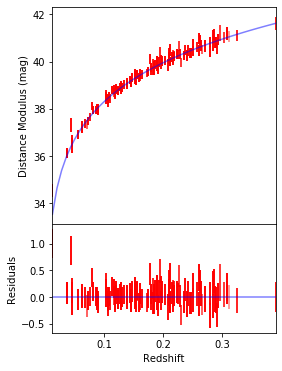

In [38]:
plot_hubble_diagram(redshift, dist_mod, dist_mod_err, our_cosmo)
